<a href="https://colab.research.google.com/github/ragalaa/Machine-Learning-Basics/blob/master/Monte_Carlo_Simulation_for_Generating_Stock_Price_Prediction_Intervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install yfinance
!pip install Fitter
### MEDIUM ARTICLE:https://towardsdatascience.com/stock-price-prediction-intervals-using-monte-carlo-simulation-6b52b8ac9c27
### GITHUB : https://github.com/jkclem/Monte-Carlo-Simulation-for-Generating-Stock-Price-Prediction-Intervals/blob/master/Daily%20Monte%20Carlo%20Simulation%20for%20Stock%20Price%20Prediction%20Intervals.ipynb

<function matplotlib.pyplot.show>

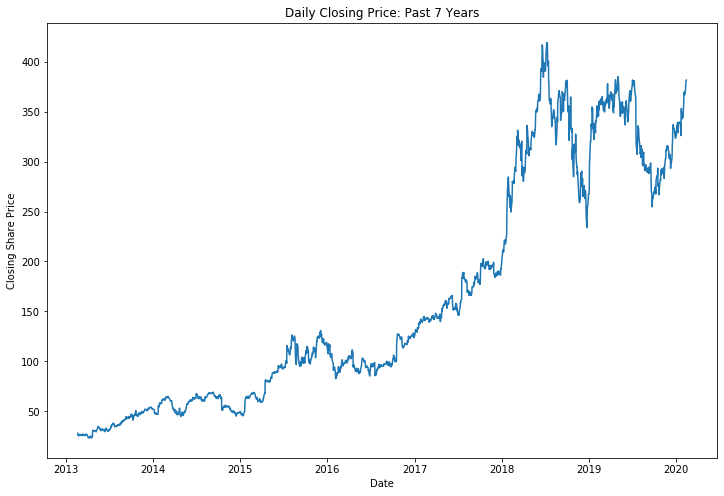

In [89]:
# imports datetime for picking beginning and end dates for the analysis
import datetime
# imports yahoo finance for getting historical stock prices

import yfinance as yf
# imports pandas for dataframe manipulation
import pandas as pd
# imports numpy
import numpy as np
# for data visualization
import matplotlib as mpl
# for changing the plot size in the Jupyter Notebook output
%matplotlib inline
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)
# for shorter lines with plotting
from matplotlib import pyplot as plt
# to hide warning messages
import warnings
warnings.filterwarnings('ignore')

# sets the sample period as 5 years back from 2/2/2020
end = datetime.datetime(2020, 2, 16)
start = end - datetime.timedelta(days = 7*365)


# gets the closing price fo Netflix for the past 5 years
my_stock = yf.Ticker('NFLX')
my_stock = pd.DataFrame(my_stock.history(start = start, end = end)['Close'])
my_stock = my_stock.rename(str.lower, axis = 'columns')


# # grabs the last 100 observations, which will be reduced to 50 for the purpose of fitting a
# # distribution for Monte Carlo simulation
my_stock_resid_distr_fitting = my_stock[-500:]

# # creates a training subset missing the final 100 observations, which are being withheld
my_stock_train = my_stock[~my_stock.isin(my_stock_resid_distr_fitting).all(1)]
# # grabs the final 50 observations for a test set
my_stock_test = my_stock_resid_distr_fitting[-250:]

# # reduces the distribution fitting dataset to 50 observations
my_stock_resid_distr_fitting = my_stock_resid_distr_fitting[~my_stock_resid_distr_fitting.isin(my_stock_test).all(1)]



# plots the my_stock weekly closing price over the past 5 years
plt.plot(my_stock.index, my_stock.close)
plt.title('Daily Closing Price: Past 7 Years')
plt.xlabel('Date')
plt.ylabel('Closing Share Price')
plt.show

Auto-Correlation Function Plots
The line of the ACF shows strong postive auto-correlation for the first 450, or so, lags. Then there is a long period of negative auto-correlation. This is a good indication that the stock price is non-stationary.

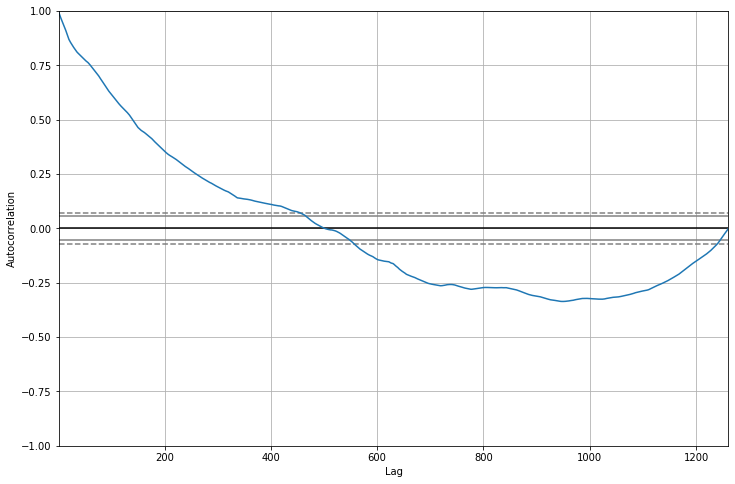

In [90]:
# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the ACF for the entire train period
pd.plotting.autocorrelation_plot(my_stock_train.close)
plt.show()

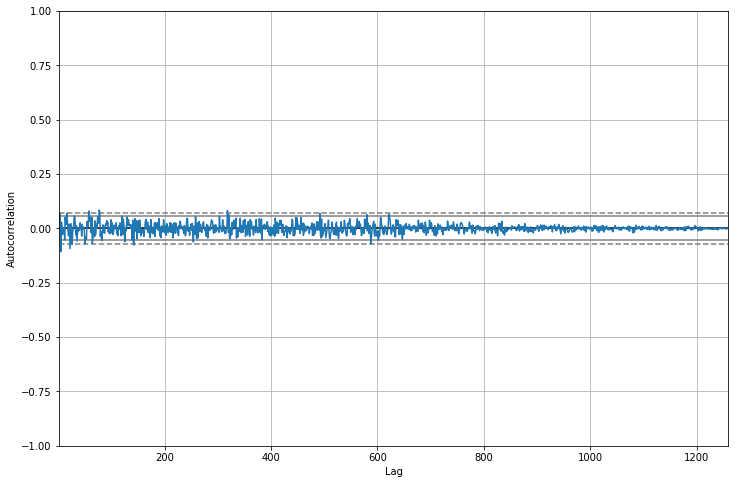

In [91]:
#The ACF plot for the differenced stock prices, however, looks stationary. This suggests the stock price is I(1)
# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)


# plots the ACF for the differenced data over the entire train period
pd.plotting.autocorrelation_plot(my_stock_train.close.diff().dropna())

B. Augmented Dickey-Fuller Tests
The ADF tests confirm that the stock price is not stationary, but its first difference is. This means the stock price is integrated to the order 1 and will need to be differenced one time for modeling.

In [92]:
# to suppress warnings
warnings.filterwarnings('ignore')

# imports the Augmented Dickey-Fuller Test for establishing the order of integration of 
# time series
from statsmodels.tsa.stattools import adfuller

# performs ADF tests with no constant, a constant, and a constant plus linear trend on
# NFLX closing share prices
for i in ['nc', 'c', 'ct']:
    result = adfuller(my_stock_train.close, regression = i)
    print('ADF Statistic with %s for Closing my_stock price: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

# performs ADF tests with no constant, a constant, and a constant plus linear trend on
# differenced NFLX closing share prices
for i in ['nc', 'c', 'ct']:
    result = adfuller(my_stock_train.close.diff().dropna(), regression = i)
    print('ADF Statistic with %s for Differenced Closing my_stock price: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

ADF Statistic with nc for Closing my_stock price: 2.906584
p-value: 0.999687

ADF Statistic with c for Closing my_stock price: 1.700504
p-value: 0.998130

ADF Statistic with ct for Closing my_stock price: -0.109885
p-value: 0.992933

ADF Statistic with nc for Differenced Closing my_stock price: -7.223841
p-value: 0.000000

ADF Statistic with c for Differenced Closing my_stock price: -7.618524
p-value: 0.000000

ADF Statistic with ct for Differenced Closing my_stock price: -7.847151
p-value: 0.000000



III. Estimating a Simple ARIMA Model
Here I estimated a simple ARIMA model of order (1, 1, 1) on the natural logarithm of the differenced stock prices to control for heteroskedasticity. The residuals on the training data set appear stationary, but somewhere there are some big spikes giving a long tails to the distribution of residuals. As just mentioned, the distribution of residuals have long tails, and the center of the distribution is a sharp peak around zero. Because the mean of the distributions is roughly zero, it seems reasonable to proceed with this simple model. We just need to keep in mind the residuals may be differently distributed than a normal distribution because of the long tails and sharp peak.

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1260
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2764.075
Method:                       css-mle   S.D. of innovations              0.027
Date:                Fri, 14 Feb 2020   AIC                          -5520.150
Time:                        19:44:22   BIC                          -5499.595
Sample:                             1   HQIC                         -5512.426
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0018      0.001      2.282      0.023       0.000       0.003
ar.L1.D.close     0.1825      0.534      0.342      0.732      -0.864       1.229
ma.L1.D.close    -0.1424      0.537     

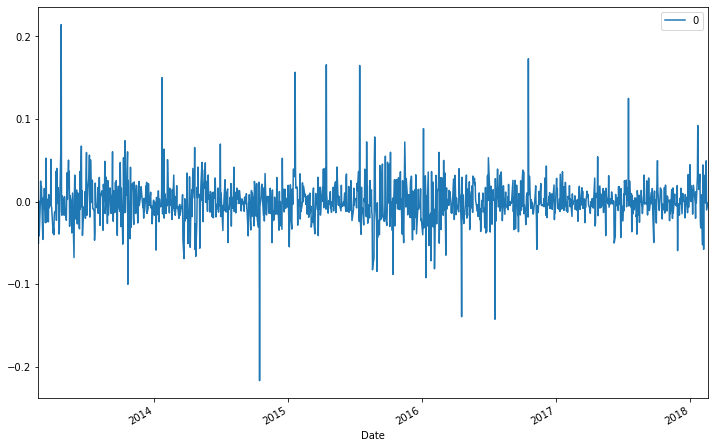

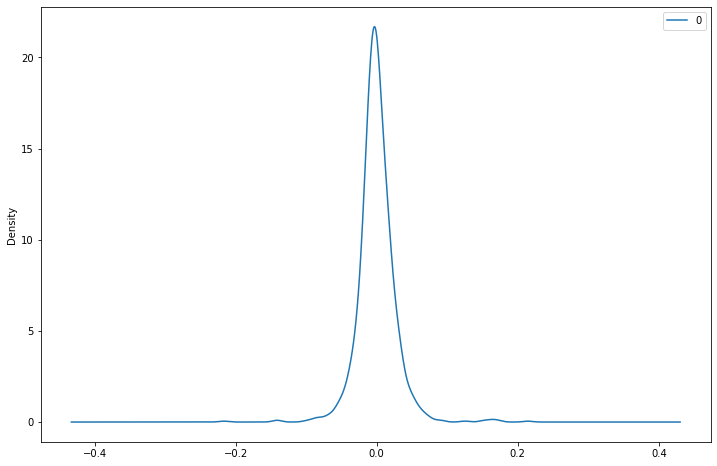

                 0
count  1260.000000
mean      0.000002
std       0.026991
min      -0.217048
25%      -0.012307
50%      -0.001565
75%       0.012152
max       0.214416


In [94]:
# to suppress warnings
warnings.filterwarnings('ignore')

# imports the ARIMA model
from statsmodels.tsa.arima_model import ARIMA

# fits the ARIMA model
my_stock_arima = ARIMA(np.log(my_stock_train.astype(float)), order = (1, 1, 1))
my_stock_arima_fit = my_stock_arima.fit( disp = 0)
print(my_stock_arima_fit.summary())

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plot residual errors of the training data
residuals = pd.DataFrame(my_stock_arima_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

**IV.** Picking a Distribution for Predictions
After choosing a simple ARIMA model, I performed a rolling forecast on one of the withheld data sets and examined the residuals. It's roughly bell-shaped and appears to be centered at 0. The fitting function indicates the Laplacian distribution is a reasonable distribution to use for our Monte Carlo simulations. Here is an example of automatically assuming a normal distribution getting you into trouble. Often times a different distribution is a better fit, empirically or theoretically (based on existence of bounds, etc). The Laplacian distribution is often a good fit for stock returns because of its fat tails, but again, always check first.

Test MSE: 88.462


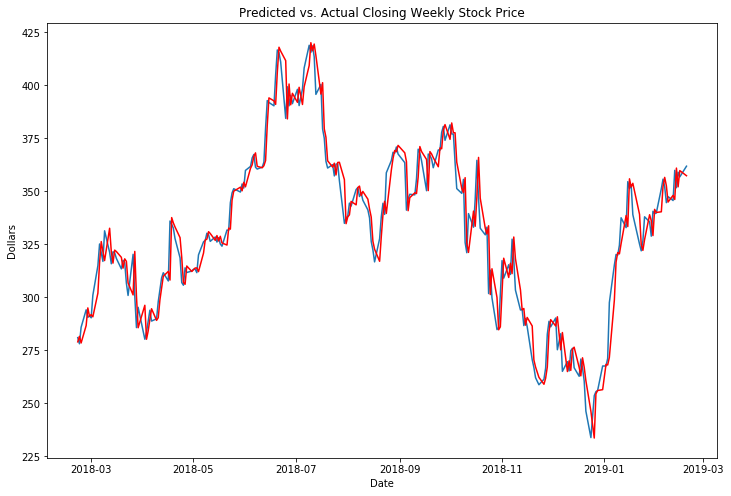

In [95]:
# to suppress warnings
warnings.filterwarnings('ignore')

# imports the mean squared error function
from sklearn.metrics import mean_squared_error

# from https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

# creates a new dataframe that will be added to as the forecast rolls 
history = np.log(my_stock_train.astype(float))
# creates an empty list that will hold predictions
predictions = []
# loops through the indexes of the set being forecased
for i in range(len(my_stock_resid_distr_fitting)):
    # estimates an ARIMA model of order (1,1,1)
    model = ARIMA(history, order = (1,1,1))
    # fits the model
    model_fit = model.fit(disp = 0)
    # forecasts the next period
    output = model_fit.forecast()
    # takes the predicted value and saves it in yhat
    yhat = np.e ** output[0]
    # appends yhat to the list of predictions
    predictions.append(yhat)
    # grabs the observation at the ith index
    obs = my_stock_resid_distr_fitting[i : i + 1]
    # appends the observation to the estimation data set
    history = history.append(np.log(obs.astype(float)))

# prints the MSE of the model for the rolling forecast period
error = mean_squared_error(my_stock_resid_distr_fitting, predictions)
print('Test MSE: %.3f' % error)

# converts the predictions list to a pandas dataframe with the same index as the actual values
# for plotting purposes
predictions = pd.DataFrame(predictions)
predictions.index = my_stock_resid_distr_fitting.index

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the predicted and actual stock prices 
plt.plot(my_stock_resid_distr_fitting)
plt.plot(predictions, color = 'red')
plt.xlabel('Date')
plt.ylabel('Dollars')
plt.title('Predicted vs. Actual Closing Weekly Stock Price')
plt.show()

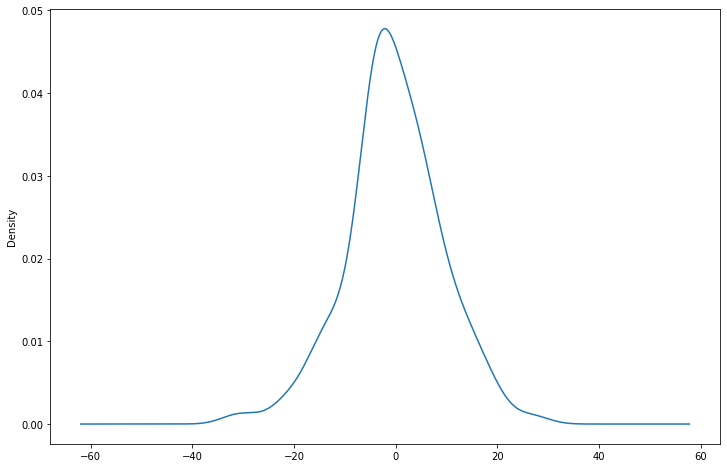

In [96]:
# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the residuals
tune_residuals = my_stock_resid_distr_fitting.close - predictions[0]
tune_residuals.plot(kind = 'kde')

In [97]:
# to suppress warnings
warnings.filterwarnings('ignore')

# produces a summary of the residuals
tune_residuals.astype(float).describe()

count    250.000000
mean      -0.256074
std        9.420819
min      -31.989995
25%       -4.912641
50%       -0.697569
75%        5.250337
max       27.868485
dtype: float64

In [99]:
# to suppress warnings
warnings.filterwarnings('ignore')


# imports the fitter function and produces estimated fits for our residuals
from fitter import Fitter


f = Fitter(tune_residuals)
f.fit()
f.summary

Fitted alpha distribution with error=0.013066355552642132)
Fitted anglit distribution with error=0.023571978693559606)
Fitted arcsine distribution with error=0.06301854963109042)
Fitted argus distribution with error=0.029323162031992138)
Fitted beta distribution with error=0.012821289066039541)
Fitted betaprime distribution with error=0.013121396987006486)
Fitted bradford distribution with error=0.038358815494730664)
Fitted burr distribution with error=0.17305420748526407)
Fitted burr12 distribution with error=0.013750201646206914)
Fitted cauchy distribution with error=0.013415122307967101)
Fitted chi distribution with error=0.04314052188412741)
Fitted chi2 distribution with error=0.013046155782552308)
Fitted cosine distribution with error=0.01819884008454972)
Fitted crystalball distribution with error=nan)
Fitted dgamma distribution with error=0.010653703803502277)
Fitted dweibull distribution with error=0.010867925933732833)
Fitted erlang distribution with error=0.012799898599108203)

<bound method Fitter.summary of <fitter.fitter.Fitter object at 0x7f5eff9c66d8>>

,sumsquare_error,aic,bic,kl_div
dgamma,0.010654,968.642325,-2499.262765,inf
dweibull,0.010868,968.991769,-2494.285697,inf
hypsecant,0.011301,964.617894,-2490.048979,inf
norminvgauss,0.011458,972.118568,-2475.543056,inf
tukeylambda,0.011474,971.700965,-2480.710069,inf


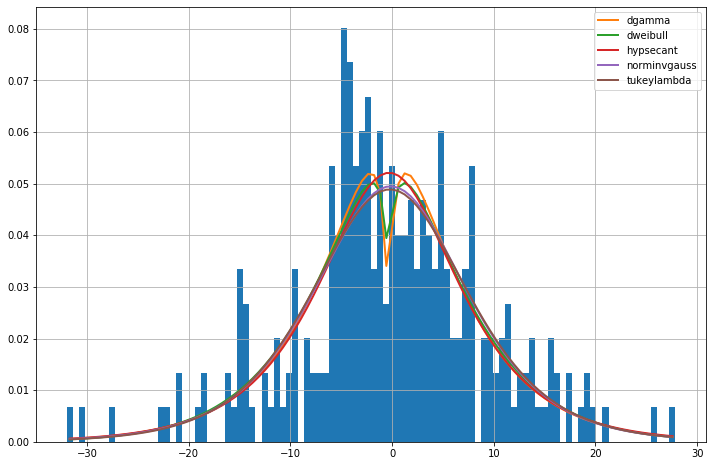

In [100]:
f.summary(method= 'sumsquare_error')

**V.** Using Monte Carlo Simulation to Predict Stock Price Intervals
Now we can generate empirically derived prediction intervals using our chosen distribution (Laplacian), mean (the residuals were centered at zero, so this will just be our predicted stock price), beta (calculated from the residuals as the mean absolute distance from the mean), and number of simulations, which is chosen by the user. I chose to do 1000. There are techniques to pick a number of simulations to ensure that the simulated distribution converges towards the actual distribution, but that is for another article. Here, I'm just doing 1000 because I think it should be enough. A little handwavey, I know.

In [0]:
def laplace_monte_carlo(mean, residuals, n_sims):
    # gets the estimated beta or mean absolute distance from the mean
    beta = (sum(abs(residuals - np.mean(residuals))) 
                           / len(residuals))
    # uses the numpy function to generate an array of simulated values
    est_range = np.random.laplace(mean, beta, n_sims)
    # converts the array to a list
    est_range = list(est_range)
    # returns the simulated values
    return(est_range)

def roll_forecast_nmc(train, test, std_dev, n_sims):
    # creates a new dataframe that will be added to as the forecast rolls 
    history = np.log(train.astype(float))
    # creates an empty list that will hold predictions
    predictions = []
    # loops through the indexes of the set being forecased
    for i in range(len(test)):
        # estimates an ARIMA model of order (1,1,0)
        model = ARIMA(history, order = (1,1,1))
        # fits the model
        model_fit = model.fit(disp = 0)
        # forecasts the next period
        output = model_fit.forecast()
        # takes the predicted value and saves it in yhat
        yhat = np.e ** output[0]
        # performs monte carlo simulation using the predicted price as the mean, user-specified
        # standard deviation, and number of simulations
        yhat_range = laplace_monte_carlo(yhat, std_dev, n_sims)
        # appends yhat_range to the list of predictions
        predictions.append([float(i) for i in yhat_range])
        # grabs the observation at the ith index
        obs = test[i : i + 1]
        # appends the observation to the estimation data set
        history = history.append(np.log(obs.astype(float)))

    # converts the predictions list to a pandas dataframe with the same index as the actual 
    # values for plotting purposes
    predictions = pd.DataFrame(predictions)
    predictions.index = my_stock_resid_distr_fitting.index
    # converts all the estimated yhats in each column to one list per row
    predictions['predicted_range'] = predictions.values.tolist()
    # grabs only the column with all values in a list
    predictions = pd.DataFrame(predictions['predicted_range'])
        
    # returns predictions
    return(predictions)

In [0]:
# attaches the data withheld for investigating the forecast residuals back to the training
# data set to avoid a large error on the first forecast
my_stock_train = my_stock_train.append(my_stock_resid_distr_fitting)


# produces a rolling forecast with prediction intervals using 1000 MC sims
test_preds = roll_forecast_nmc(my_stock_train, 
                               my_stock_test, 
                               tune_residuals,
                              1000)

The percentage of actual week ahead stock prices within our prediction interval is 99.6%. That is pretty good, especially for our simple ARIMA model that hasn't been tuned. Using a different model that accounted for financial statement data, sentiment analysis of tweets, et cetera could produce a better model, but this simple one worked decently well.

In [103]:
# creates an empty list
in_prediction_interval = []
# loops through the rows in the testing data set
for i in range(len(my_stock_test)):
    # appends true if the actual price is in the interval of predicted prices and false
    # otherwise
    in_prediction_interval.append(np.where(min(test_preds.predicted_range[i]) <= 
                                           my_stock_test.close[i]
                                          <= max(test_preds.predicted_range[i]), 
                                           True, False))
# prints the percentage of actual prices in the prediction intervals    
print('Percentage of Actual Stock Prices in Predicted Stock Price Range: %f' % 
      (100 * sum(in_prediction_interval) / len(in_prediction_interval)))

Percentage of Actual Stock Prices in Predicted Stock Price Range: 100.000000


I plotted the prediction intervals along with the actual stock prices and the actual price does appear to generally be in the middle of our prediction intervals, which is exactly what we want

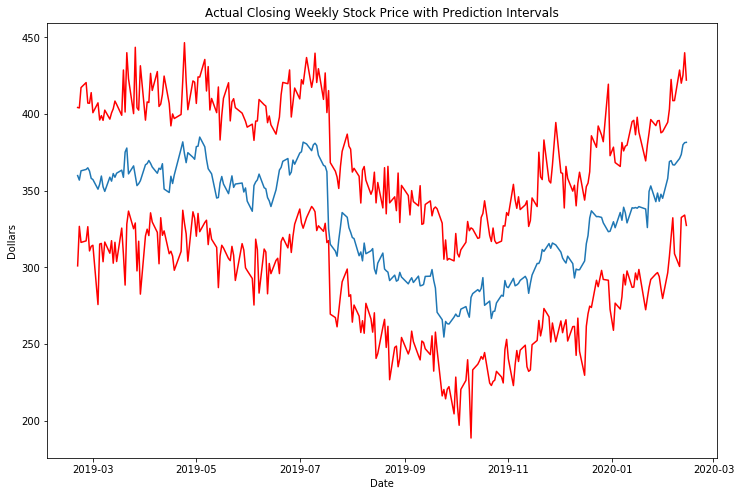

In [104]:
# creates empty lists to append to with minimum and maximum values for each weeks prediction
min_range = []
max_range = []

# loops through the rows in test_preds
for i in range(len(test_preds)):
    # appends to the list the min or max value as appropriate
    min_range.append(min(test_preds.predicted_range[i]))
    max_range.append(max(test_preds.predicted_range[i]))

# converts the lists to data frames and makes their indexes match up with the dates they're
# predicting
min_range = pd.DataFrame(min_range)
min_range.index = my_stock_test.index
max_range = pd.DataFrame(max_range)
max_range.index = my_stock_test.index

# plots the actual stock price with prediction intervals
plt.plot(my_stock_test)
plt.plot(min_range, color = 'red')
plt.plot(max_range, color = 'red')
plt.xlabel('Date')
plt.ylabel('Dollars')
plt.title('Actual Closing Weekly Stock Price with Prediction Intervals')
plt.show()

**VI. Conclusions**
So what are potential applications of pairing Monte Carlo simulation and time series modeling in investing? Prediction intervals generated using Monte Carlo simulation can be used to predict the probability that an option is in the money or if a stock is a buy, hold, or sell over you chosen time horizon (again, please do not start trying to trade options using this model or pursue any other type of investing strategy without careful consideration and backtesting). I did this below where I calculated the probability that the stock price on 09/12/2019 is greater than or equal to 290 and got the probability of 35.6%.

In [110]:
# sets a target price to see the probability that the actual stock price is greater than or 
# equal to this target
target_price = 400
# creates a list of True values where the simulated price is above or equal to the target price
# and False where it is below
above_target = [i >= target_price for i in test_preds.predicted_range[len(test_preds) - 1]]
# prints the probability
print('Probability Actual Stock Price is above Strike Price: %f' % 
      (sum(above_target) / len(above_target)))

Probability Actual Stock Price is above Strike Price: 0.027000


In [108]:
my_stock_test.tail(2)

,close
Date,
2020-02-13,381.40
2020-02-14,381.58
